In [2]:
import numpy as np
import pandas as pd
import os 
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib
from utils import get_best_configuration, calculate_cost, get_top_k_configs_from_data, \
    get_top_per_type_configs_from_data, get_result_from_data, ondemand_pricing, spot_pricing, calculate_cpu_mem_costs

## Settings and configurations

In [3]:
benchmarks = {"transcode": "cats-1", "pigo-faceblur": "faces2", "pigo-face-detector": "faces2", "openfaas-ocr": "doc", "linpack": "2500", "s3": "cats-1"}
# benchmarks = {"linpack": "2500"}
# benchmarks ={"classifier": "bridge-8k-1920x1200"}
base_estimators = ['GP', 'GBRT', 'ET', 'RF']
# base_estimators = ['GP']
CPU_LIMITS= [ '250m', '500m', '750m', '1000m', '1250m', '1500m', '1750m', '2000m' ]
# MEMORY_LIMITS=[ '256Mi', '512Mi', '768Mi', '1024Mi' ]
MEMORY_LIMITS=[ '128Mi', '256Mi', '512Mi', '768Mi', '1024Mi', '2048Mi' ]
instance_types = ['m5', 'm5a', 'c5', 'c5a', 'c6g', 'm6g']

benchmark_naming = {"transcode": "transcode", "pigo-faceblur": "faceblur", "pigo-face-detector": "facedetect", "classifier": "classifier", "linpack": "linpack", "s3": "s3", "openfaas-ocr": "ocr"}

N_TRAILS = 20
N_INIT_SAMPLES = 3
N_OPT_TRAILS = 10

calculate_cpu_mem_costs()
data_dir = 'analysis_data/'

## Helper functions

In [18]:
import random 
def get_random_samples(cpu_limits, memory_limits, instance_types, seed=1, n_samples=3):
    
    random_samples = []
    random.seed(seed)

    for i in range(0, n_samples):
        
        cpu = random.choice(cpu_limits)
        mem = random.choice(memory_limits)
        inst_type = random.choice(instance_types)
        random_samples.append({"instance_type": inst_type, "cpu": cpu.replace("m", ""), "memory": mem.replace("Mi", "")})

    return random_samples


In [19]:
def error_across_top_k(model, function_name, k=5):
    model_top_k = model.get_top_k_configs(function_name)
    # print(model_top_k)

    actual_model_top_k = []
    for i in range(0, k):
        conf = model_top_k[i][1]
        config = {'instance_type': conf[0], 'cpu': conf[1], 'memory': conf[2]}
        result = get_result_from_data(function_name, data_name, config, MEMORY_LIMITS)
        actual_model_top_k.append((result, conf))
    # print(actual_model_top_k)

    data_top_k = get_top_k_configs_from_data(instance_types, CPU_LIMITS, MEMORY_LIMITS, function_name, data_name)
    # print(data_top_k)

    mae = 0.0
    for i in range(0, k):
        mae += abs(model_top_k[i][0]-data_top_k[i][0])
    
    mae = mae/5.0

    return mae

In [20]:
def error_across_top_per_types(model, function_name, marker='all', metric='runtime'):
    model_top_per_type = model.get_top_across_types(function_name)
    # print(model_top_k)

    k = len(instance_types)

    actual_model_top_per_type = []
    for i in range(0, k):
        conf = model_top_per_type[i][1]
        config = {'instance_type': conf[0], 'cpu': conf[1], 'memory': conf[2]}
        result = get_result_from_data(function_name, data_name, config, MEMORY_LIMITS, metric=metric)
        actual_model_top_per_type.append((result, conf))
    # print(actual_model_top_k)

    data_top_per_type = get_top_per_type_configs_from_data(instance_types, CPU_LIMITS, MEMORY_LIMITS, function_name, data_name, metric=metric)
    # print(data_top_per_type)
    # print(model_top_per_type)

    mae = 0.0
    for i in range(0, k):
        # print(data_top_per_type[i][0], actual_model_top_per_type[i][0])
        # The reason why we don't use the actual performance of the configuration suggested by the model is that the decisions are going
        # To be made on the prediction not the actual runtime until the configuration has been executed
        mae += abs(model_top_per_type[i][0]-data_top_per_type[i][0])/data_top_per_type[i][0]
    
    mae = 100*mae/float(k)

    return mae

In [21]:
def get_individual_error_across_all_configs(model, function_name, errors_violin, x, base_estimator, metric='runtime'):
    model_all_predictions = model.get_all_config_predictions(function_name)
    # print(model_top_k)

    actual_performance = []
    for i in range(0, len(model_all_predictions)):
        conf = model_all_predictions[i][1]
        config = {'instance_type': conf[0], 'cpu': conf[1], 'memory': conf[2]}
        result = get_result_from_data(function_name, data_name, config, MEMORY_LIMITS, metric=metric)
        actual_performance.append((result, conf))

    mape = 0.0
    for i in range(0, len(model_all_predictions)):
        mape = 100*abs(model_all_predictions[i][0]-actual_performance[i][0])/actual_performance[i][0]
        errors_violin = errors_violin.append({'benchmark': function_name, 'trials': x, 'mape': mape, 'estimator': base_estimator}, ignore_index=True)
    
    # mae = 100*mae/float(len(model_all_predictions))

    return errors_violin

In [22]:
def error_across_all_configs(model, function_name, metric='runtime'):
    model_all_predictions = model.get_all_config_predictions(function_name)
    # print(model_top_k)

    actual_performance = []
    for i in range(0, len(model_all_predictions)):
        conf = model_all_predictions[i][1]
        config = {'instance_type': conf[0], 'cpu': conf[1], 'memory': conf[2]}
        result = get_result_from_data(function_name, data_name, config, MEMORY_LIMITS, metric=metric)
        actual_performance.append((result, conf))

    mae = 0.0
    for i in range(0, len(model_all_predictions)):
        e = abs(model_all_predictions[i][0]-actual_performance[i][0])/actual_performance[i][0]
        # if e*100 > 50.0:
        #     print(actual_performance[i][0], model_all_predictions[i])
        mae += e
    
    mae = 100*mae/float(len(model_all_predictions))

    return mae

## Run optimization algorithms and create models 
**Note that this is a long running process that can take 30+ mins **

In [ ]:
violations = pd.DataFrame(columns=['benchmark', 'trials', 'violations', 'estimator'])
errors = pd.DataFrame(columns=['benchmark', 'trials', 'mape', 'estimator'])
errors_across_types = pd.DataFrame(columns=['benchmark', 'trials', 'mape', 'estimator'])
errors_violin = pd.DataFrame(columns=['benchmark', 'trials', 'mape', 'estimator'])

for function_name in benchmarks.keys():
    print(function_name)
    runtimes = pd.DataFrame(columns=['trials', 'runtime', 'estimator'])
    data_name = benchmarks[function_name]
    minimum_runtime, _, _ = get_best_configuration(instance_types, CPU_LIMITS, MEMORY_LIMITS, function_name, data_name)
    for x in range(0, N_OPT_TRAILS):
        for base_estimator in base_estimators:
            # print(base_estimator)
            minimum = 600.0

            init_samples = get_random_samples(CPU_LIMITS, MEMORY_LIMITS, instance_types, seed=x)

            default_config = init_samples[0]
            config = default_config
            # print(config)
            
            if base_estimator != "poly":
                from optimizer.boskopt import Models
                model = Models()
                model.create_model(function=function_name, base_estimator=base_estimator, seed=x)
            else:
                from optimizer.polyreg import Models
                model = Models()
                model.create_model(function=function_name)

            v = 0 

            violation_et = 1.5 * minimum_runtime

            for i in range(0, N_TRAILS):
                success = True
                result = get_result_from_data(function_name, data_name, config, MEMORY_LIMITS)
                # print(config, result) 

                if result < minimum:
                    minimum = result

                if result > violation_et:
                    v += 1

                # if result == -1.0:
                #     success=False

                model.update(config, result, function_name, success=True)
                
                if i < N_INIT_SAMPLES-1:
                    config = init_samples[i+1]
                else:
                    config = model.get_next_config(function_name)
                

                runtimes = runtimes.append({'trials': i, 'runtime': minimum, 'estimator': base_estimator}, ignore_index=True)

            violations = violations.append({'benchmark': function_name, 'opt. trials': x, 'violations': v, 'estimator': base_estimator}, ignore_index=True)


            mae = error_across_top_per_types(model, function_name)
            errors_across_types = errors_across_types.append({'benchmark': function_name, 'trials': x, 'mape': mae, 'estimator': base_estimator}, ignore_index=True)

            mae = error_across_all_configs(model, function_name)
            errors = errors.append({'benchmark': function_name, 'trials': x, 'mape': mae, 'estimator': base_estimator}, ignore_index=True)

            errors_violin = get_individual_error_across_all_configs(model, function_name, errors_violin, x, base_estimator)
 
# print(errors)
    runtimes.to_csv(data_dir + 'runtimes-' +function_name+ '.csv', index=False)
    # print(runtimes)

violations.to_csv(data_dir + 'violations.csv', index=False)#, header=False, mode='a')
errors_across_types.to_csv(data_dir + 'errors_across_types.csv', index=False)#, header=False, mode='a')
errors.to_csv(data_dir + 'errors.csv', index=False)#, header=False, mode='a')
errors_violin.to_csv(data_dir + 'errors_violin.csv', index=False)#, header=False, mode='a')


## Load Data from files and plot
The following two cells load data from csv files and plot them. 

## For execution time objective

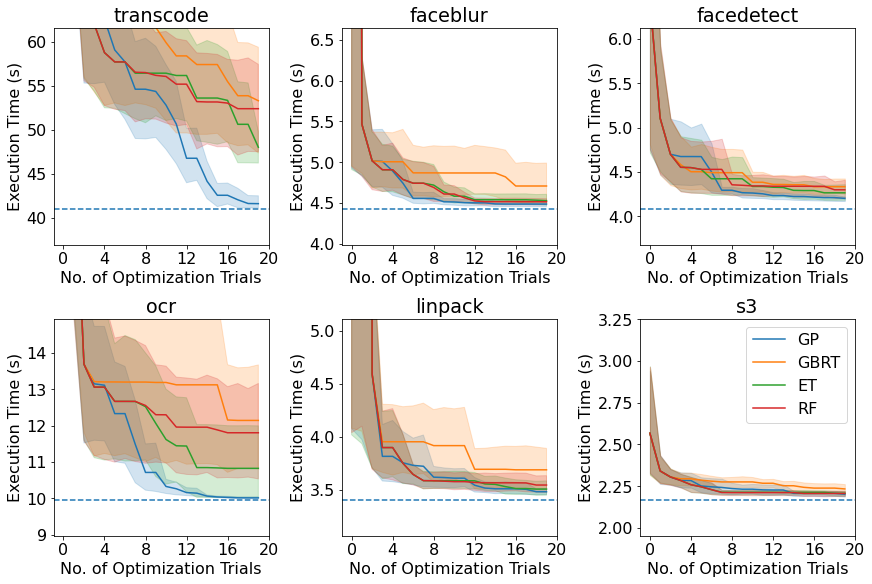

In [7]:
# benchmarks = {"transcode": "cats-1", "pigo-faceblur": "faces2", "pigo-face-detector": "faces2", "openfaas-ocr": "doc", "linpack": "2500", "s3": "cats-1"}
matplotlib.rcParams.update({'font.size': 16})
fig, axs = plt.subplots(figsize=(12, 8), ncols=3, nrows=2, constrained_layout=True)
j = 0
i = 0
for function_name in benchmarks.keys():
    data_name = benchmarks[function_name]
    minimum_runtime, _, _ = get_best_configuration(instance_types, CPU_LIMITS, MEMORY_LIMITS, function_name, data_name)

    runtimes = pd.read_csv(data_dir + 'runtimes-'+function_name+'.csv')
    # plt.figure()
    ax = sns.lineplot(data=runtimes, x='trials', y='runtime', hue='estimator', ax=axs[i][j])
    j += 1
    ax.axhline(minimum_runtime, ls='--')
    # ax.text(0.5,minimum_runtime+10, "Minimum")
    ax.set_xticks(np.arange(0, 22, 4))
    ax.set_ylim((minimum_runtime * 0.9, minimum_runtime*1.5))
    ax.set_title(benchmark_naming[function_name])
    # plt.show()
    # if j != len(benchmarks.keys()):
    ax.legend().set_visible(False)
    
    ax.set_ylabel("Execution Time (s)")
    ax.set_xlabel("No. of Optimization Trials")
    
    if j == 3:
        i += 1
        j = 0

plt.legend(ncol=1, loc='upper right')
plt.savefig('plots/et_2.pdf', bbox_inches = "tight")
plt.show()

## For Execution Cost Objective

In [ ]:
# benchmarks = {"openfaas-ocr": "doc"}

violations = pd.DataFrame(columns=['benchmark', 'trials', 'violations', 'estimator'])
errors = pd.DataFrame(columns=['benchmark', 'trials', 'mape', 'estimator'])
errors_across_types = pd.DataFrame(columns=['benchmark', 'trials', 'mape', 'estimator'])
errors_violin = pd.DataFrame(columns=['benchmark', 'trials', 'mape', 'estimator'])
data_dir = 'analysis_data/'
for function_name in benchmarks.keys():
    print(function_name)
    costs = pd.DataFrame(columns=['trials', 'cost', 'estimator'])
    data_name = benchmarks[function_name]
    minimum_cost, _, _ = get_best_configuration(instance_types, CPU_LIMITS, MEMORY_LIMITS, function_name, data_name, metric='cost')
    for x in range(0, N_OPT_TRAILS):
        for base_estimator in base_estimators:
            # print(base_estimator)
            minimum = 600.0

            init_samples = get_random_samples(CPU_LIMITS, MEMORY_LIMITS, instance_types, seed=x)

            default_config = init_samples[0]
            config = default_config
            # print(config)
            
            if base_estimator != "poly":
                from optimizer.boskopt import Models
                model = Models()
                model.create_model(function=function_name, base_estimator=base_estimator, seed=x)
            else:
                from optimizer.polyreg import Models
                model = Models()
                model.create_model(function=function_name)

            v = 0 

            violation_ec = 1.5 * minimum_cost

            for i in range(0, N_TRAILS):
                success = True
                result = get_result_from_data(function_name, data_name, config, MEMORY_LIMITS, metric='cost')
                # print(config, result) 

                if result < minimum:
                    minimum = result

                if result > violation_ec:
                    v += 1

                # if result == -1.0:
                #     success=False

                model.update(config, result, function_name, success=True)
                
                if i < N_INIT_SAMPLES-1:
                    config = init_samples[i+1]
                else:
                    config = model.get_next_config(function_name)
                

                costs = costs.append({'trials': i, 'cost': minimum, 'estimator': base_estimator}, ignore_index=True)

            violations = violations.append({'benchmark': function_name, 'opt. trials': x, 'violations': v, 'estimator': base_estimator}, ignore_index=True)


            mae = error_across_top_per_types(model, function_name, metric='cost')
            errors_across_types = errors_across_types.append({'benchmark': function_name, 'trials': x, 'mape': mae, 'estimator': base_estimator}, ignore_index=True)

            mae = error_across_all_configs(model, function_name, metric='cost')
            errors = errors.append({'benchmark': function_name, 'trials': x, 'mape': mae, 'estimator': base_estimator}, ignore_index=True)

            errors_violin = get_individual_error_across_all_configs(model, function_name, errors_violin, x, base_estimator, metric='cost')
 
# print(errors)

    costs.to_csv(data_dir + 'costs-' +function_name+ '.csv', index=False)
    # print(runtimes)

violations.to_csv(data_dir + 'ec-violations.csv', index=False)#, header=False, mode='a')
errors_across_types.to_csv(data_dir + 'ec-errors_across_types.csv', index=False)#, header=False, mode='a')
errors.to_csv(data_dir + 'ec-errors.csv', index=False)#, header=False, mode='a')
errors_violin.to_csv(data_dir + 'ec-errors_violin.csv', index=False)#, header=False, mode='a')


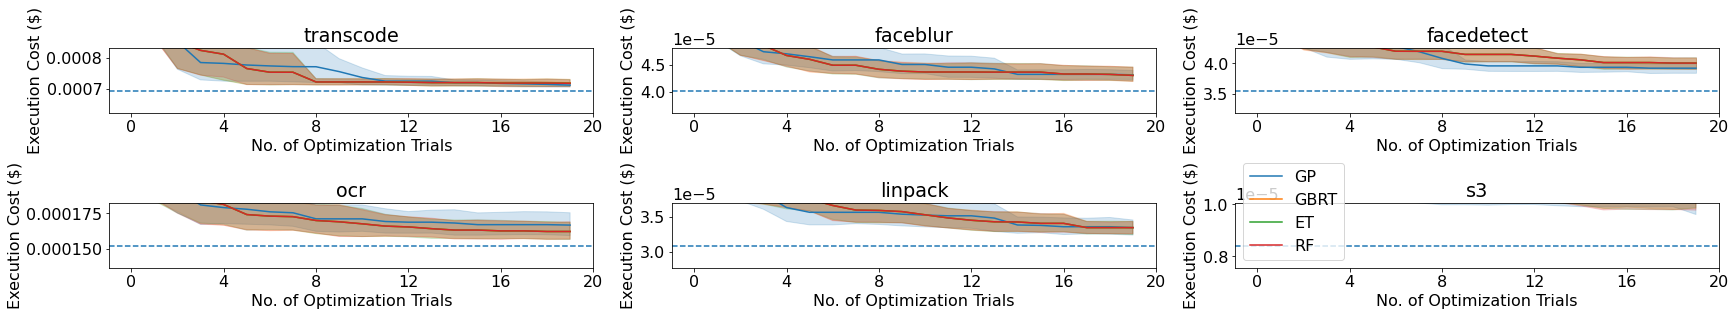

In [8]:
# benchmarks = {"transcode": "cats-1", "pigo-faceblur": "faces2", "pigo-face-detector": "faces2", "openfaas-ocr": "doc", "linpack": "2500", "s3": "cats-1"}

matplotlib.rcParams.update({'font.size': 16})
fig, axs = plt.subplots(figsize=(12, 8), ncols=3, nrows=2, constrained_layout=True)
j = 0
i = 0
for function_name in benchmarks.keys():
    data_name = benchmarks[function_name]
    minimum_cost, _, _ = get_best_configuration(instance_types, CPU_LIMITS, MEMORY_LIMITS, function_name, data_name, metric='cost')

    costs = pd.read_csv(data_dir + 'costs-'+function_name+'.csv')
    # plt.figure()
    ax = sns.lineplot(data=costs, x='trials', y='cost', hue='estimator', ax=axs[i][j])
    j += 1
    ax.axhline(minimum_cost, ls='--')
    # ax.text(0.5,minimum_runtime+10, "Minimum")
    ax.set_xticks(np.arange(0, 22, 4))
    ax.set_ylim((minimum_cost * 0.9, minimum_cost*1.2))
    ax.set_title(benchmark_naming[function_name])
    # plt.show()
    # if j != len(benchmarks.keys()):
    ax.legend().set_visible(False)
    ax.set_ylabel("Execution Cost ($)")
    ax.set_xlabel("No. of Optimization Trials")

    if j == 3:
        i += 1
        j = 0

plt.legend(ncol=1, loc='lower left')

plt.savefig('plots/ec_2.pdf', bbox_inches = "tight")

## Modeling and Prediction error

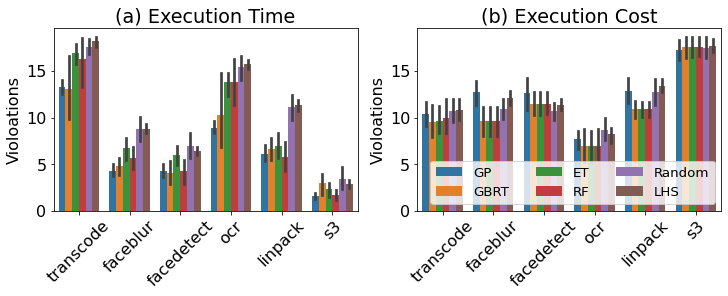

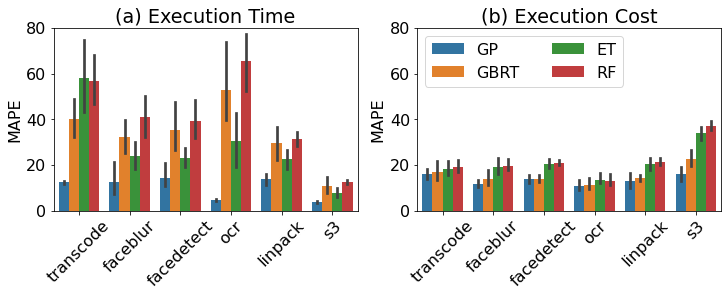

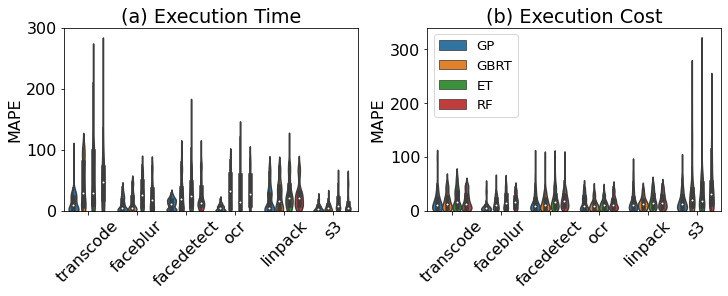

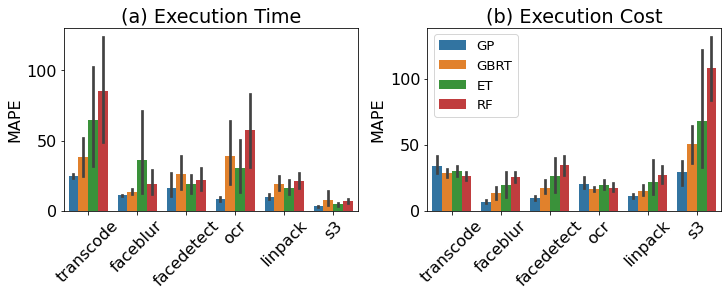

In [6]:
matplotlib.rcParams.update({'font.size': 16})
fig, axs = plt.subplots(figsize=(10, 4), ncols=2, constrained_layout=True)
j = 0
filenames = ['violations.csv', 'ec-violations.csv']
titles = ['(a) Execution Time', '(b) Execution Cost']
for filename in filenames:
    violations = pd.read_csv(data_dir + filename)
    violations.replace(benchmark_naming, inplace=True)
    violations.replace({'random': 'Random', 'lhs': 'LHS'}, inplace=True)
    ax = sns.barplot(data=violations, x='benchmark', y='violations', hue='estimator', ax=axs[j])
    ax.tick_params(axis='x', labelrotation=45)
    ax.legend().set_visible(False)
    ax.set_title(titles[j])
    ax.xaxis.label.set_visible(False)
    ax.set_ylabel("Violoations")
    j+=1

plt.legend(fontsize='small', ncol=3, loc='lower right')
plt.savefig('plots/violations.pdf', bbox_inches = "tight")


fig, axs = plt.subplots(figsize=(10, 4), ncols=2, constrained_layout=True)
j = 0
filenames = ['errors.csv', 'ec-errors.csv']
for filename in filenames:
    errors = pd.read_csv(data_dir + filename)
    errors.replace(benchmark_naming, inplace=True)
    ax = sns.barplot(data=errors, x='benchmark', y='mape', hue='estimator', ax=axs[j])
    ax.tick_params(axis='x', labelrotation=45)
    ax.legend().set_visible(False)
    ax.set_ylim(bottom=0, top=80)
    ax.set_title(titles[j])
    ax.xaxis.label.set_visible(False)
    ax.set_ylabel("MAPE")
    j+=1
    # print(errors.groupby(['estimator', 'benchmark'])["mape"].describe())

plt.legend(ncol=2, loc='upper left')
plt.savefig('plots/errors.pdf', bbox_inches = "tight")


fig, axs = plt.subplots(figsize=(10, 4), ncols=2, constrained_layout=True)
j = 0
filenames = ['errors_violin.csv', 'ec-errors_violin.csv']
for filename in filenames:
    errors_violin = pd.read_csv(data_dir + filename)
    errors_violin = errors_violin[errors_violin['trials']==0]
    errors_violin.replace(benchmark_naming, inplace=True)
    ax = sns.violinplot(data=errors_violin, x='benchmark', y='mape', hue='estimator', ax=axs[j])
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_ylim(bottom=0)
    ax.legend().set_visible(False)
    ax.set_title(titles[j])
    ax.xaxis.label.set_visible(False)
    ax.set_ylabel("MAPE")
    j+=1

plt.legend(fontsize='small', ncol=1, loc='upper left')
plt.savefig('plots/errors_violin.pdf', bbox_inches = "tight")



fig, axs = plt.subplots(figsize=(10, 4), ncols=2, constrained_layout=True)
j = 0
filenames = ['errors_across_types.csv', 'ec-errors_across_types.csv']
for filename in filenames:
    errors_across_types = pd.read_csv(data_dir + filename)
    errors_across_types.replace(benchmark_naming, inplace=True)
    ax = sns.barplot(data=errors_across_types, x='benchmark', y='mape', hue='estimator', ax=axs[j])
    ax.tick_params(axis='x', labelrotation=45)
    ax.legend().set_visible(False)
    ax.set_title(titles[j])
    ax.xaxis.label.set_visible(False)
    ax.set_ylabel("MAPE")
    j+=1

    # print(errors_across_types.groupby(['estimator', 'benchmark'])["mape"].describe())

plt.legend(fontsize='small', ncol=1, loc='upper left')
plt.savefig('plots/error_across_types.pdf', bbox_inches = "tight")


In [28]:
# 